In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
# import polars as pl
# import duckdb as dd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
# from pydicom import dcmread
import warnings
from sklearn.preprocessing import LabelEncoder
import pickle
import gc
import ctypes
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [3]:
import tensorflow as tf
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


In [30]:
config = {}

config['feature_file_path'] \
= '/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l5_s1_training_features'
config['labels_file_path'] \
= '/kaggle/input/left-neural-foraminal-narrowing-training/left_neural_foraminal_narrowing_l5_s1_feature_metadata_labels'

In [31]:
with open(config['feature_file_path'], "rb") as file:
    extracted_training_features = pickle.load(file)
    
with open(config['labels_file_path'], "rb") as file:
    labels = pickle.load(file)

In [32]:
extracted_training_features_resized = []

for img in extracted_training_features:
    extracted_training_features_resized.append(np.resize(img,(128,)))
    
final = np.array(extracted_training_features_resized)
labels_vstacked = np.vstack(labels)

print(final.shape)
print(labels_vstacked.shape)

(147083, 128)
(147083, 1)


In [48]:
with strategy.scope():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=[128]))
    model.add(tf.keras.layers.Dense(210, activation="selu"))
    model.add(tf.keras.layers.Dense(170, activation="selu"))
    model.add(tf.keras.layers.Dense(65, activation="selu"))
    model.add(tf.keras.layers.Dense(3, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adamax", metrics=["accuracy"], steps_per_execution=32)

In [46]:
x_train, x_test, y_train, y_test = train_test_split(final, labels_vstacked, test_size=0.3, random_state=42)
#keras.utils.split_dataset(data, left_size=0.8)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.2, random_state=42)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_valid.shape)
print(y_valid.shape)

(102958, 128)
(102958, 1)
(35300, 128)
(35300, 1)
(8825, 128)
(8825, 1)


In [49]:
#BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# history = model.fit(x_train, y_train, epochs=110, validation_data=(x_valid, y_valid), batch_size=BATCH_SIZE)
history_selu = model.fit(x_train, y_train, epochs=110, validation_data=(x_valid, y_valid))

Epoch 1/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.5054 - loss: 4.3607 - val_accuracy: 0.6219 - val_loss: 1.5563
Epoch 2/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.5817 - loss: 1.0980 - val_accuracy: 0.5789 - val_loss: 0.9846
Epoch 3/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6113 - loss: 0.9424 - val_accuracy: 0.6228 - val_loss: 0.9335
Epoch 4/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6183 - loss: 0.9140 - val_accuracy: 0.6108 - val_loss: 0.9197
Epoch 5/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6218 - loss: 0.8975 - val_accuracy: 0.6184 - val_loss: 0.9165
Epoch 6/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6219 - loss: 0.8954 - val_accuracy: 0.6255 - val_loss: 0.8804
Epoch 7/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6202 - loss: 0.8981 - val_accuracy: 0.6222 - val_loss: 0.8875
Epoch 8/110
3218/3218 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.6244 - loss: 

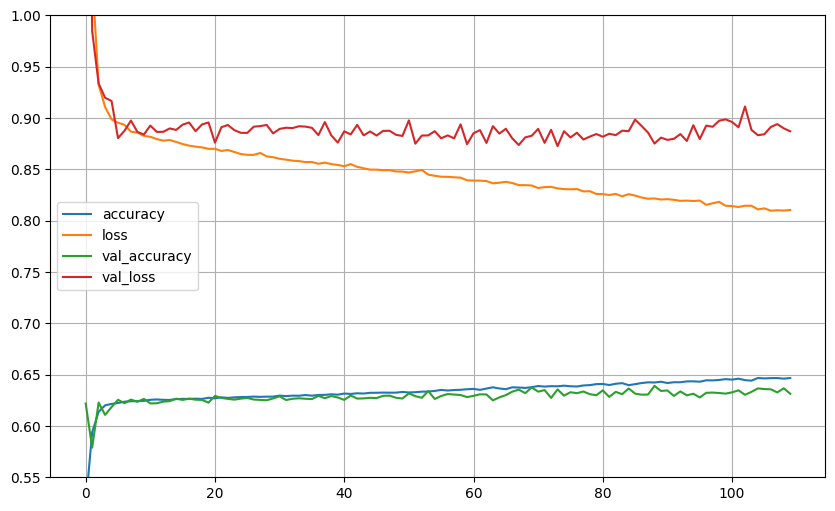

In [53]:
pd.DataFrame(history_selu.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0.55,1)
plt.show()

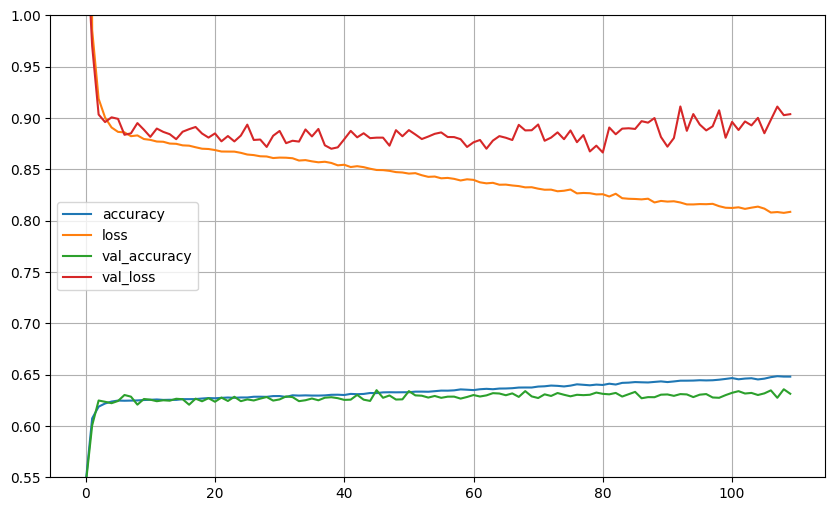

In [52]:
pd.DataFrame(history_adamax.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0.55,1)
plt.show()

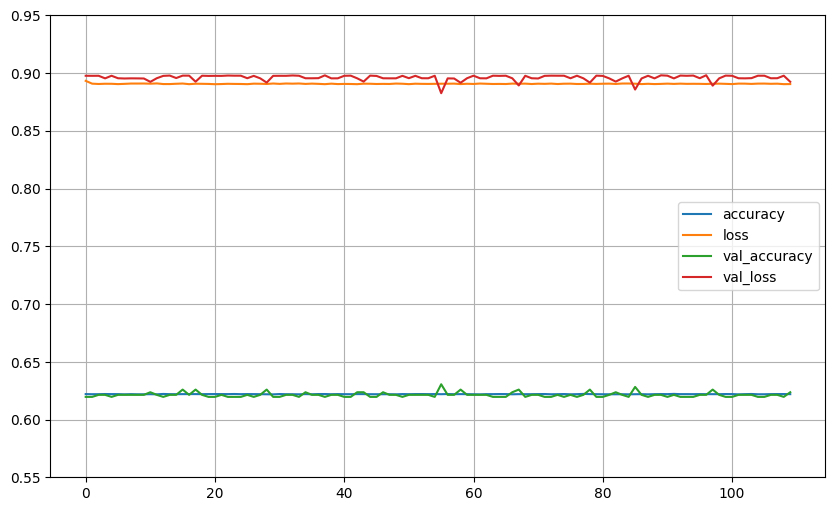

In [51]:
pd.DataFrame(history.history).plot(figsize=(10,6))
plt.grid(True)
plt.gca().set_ylim(0.55,0.95)
plt.show()

In [28]:
model.evaluate(x_test, y_test)

1104/1104 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.5984 - loss: 0.8671


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


[0.8665614724159241, 0.6004929542541504]

In [29]:
model.save("keras_base_left_neural_foraminal_narrowing_l4_l5.h5")